In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
owl_im = cv2.imread('test/owl_query.webp', cv2.IMREAD_GRAYSCALE)
test_im = cv2.imread('test/owl_place.webp', cv2.IMREAD_GRAYSCALE)

In [3]:
# see https://docs.opencv.org/4.x/db/d27/tutorial_py_table_of_contents_feature2d.html
# ORB is "best" i guess
orb = cv2.ORB_create()

In [4]:
# FLANN parameters
FLANN_INDEX_LSH = 6 # why this isnt a cv2 namespace constant?
# tutorial didnt explain why these options
# tutorial said commented out are "recommended", but failed in some cases??
index_opts= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2
# larger checks means slower but more precise
search_opts = dict(checks=100)   # or pass empty dictionary
# i guess just expose both opts
flann = cv2.FlannBasedMatcher(index_opts,search_opts)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

In [5]:
# manually specifying keypoints could have better accuracy
def calc_keypoints_descriptors(detector, img, keypoints = None):
    assert len(img.shape) == 2, 'Image must be grayscale!'
    if keypoints:
        return detector.compute(img, keypoints)
    return detector.detectAndCompute(img, None)

owl_kps = calc_keypoints_descriptors(orb, owl_im)

In [6]:
from time import perf_counter_ns

kp1, des1 = owl_kps
a = perf_counter_ns()
kp2, des2 = calc_keypoints_descriptors(orb, test_im)
#matches = flann.knnMatch(des1,des2,k=2)
good = bf.match(des1, des2)
b = perf_counter_ns()
print('ms: ', (b-a)/1e6)

if len(good) > 10:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = owl_im.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    test_im = cv2.polylines(test_im,[np.int32(dst)],True,255,3, cv2.LINE_AA)

ms:  20.676929


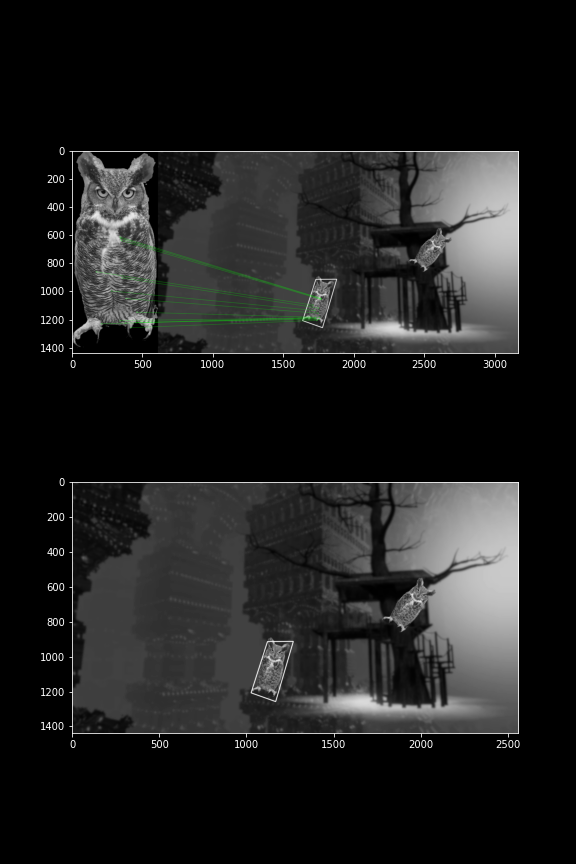

In [7]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(owl_im,kp1,test_im,kp2,good,None,**draw_params)
plt.figure(figsize=(8,12))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.imshow(img3, 'gray')
ax2.imshow(test_im, 'gray')
plt.show()

[('owl', array([[[1064.7922,  412.9987]],

       [[1020.8663,  741.4043]],

       [[1169.9683,  760.3298]],

       [[1212.5386,  429.7675]]], dtype=float32))]


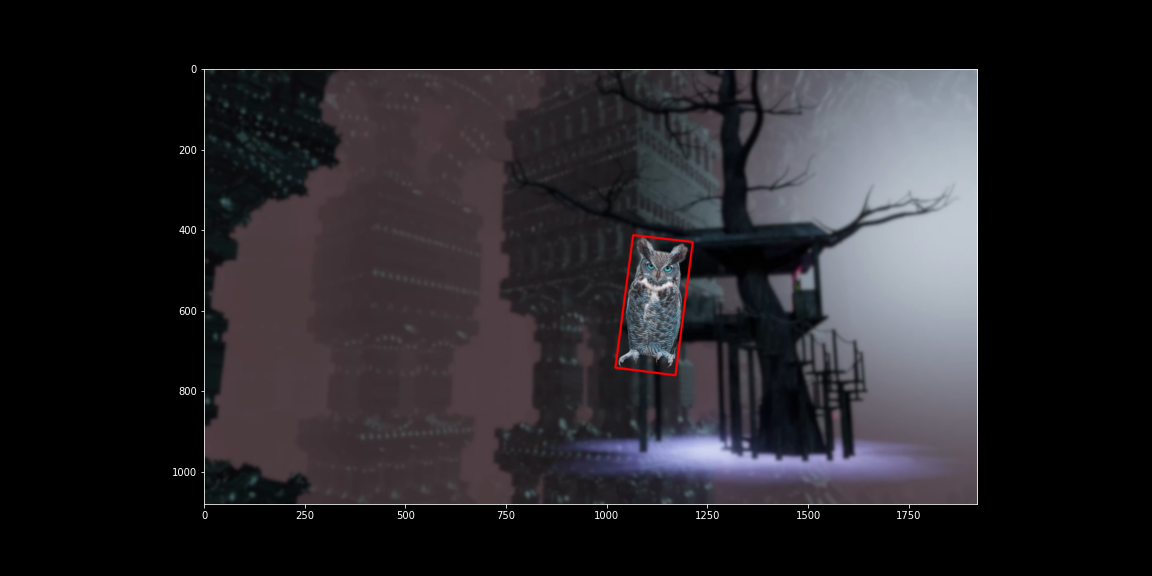

In [3]:
from nicepipe.predict.kp import KPDetPredictor
predictor = KPDetPredictor(im_map={"owl": "test/owl_query.webp"})
predictor.init()
test_im = cv2.imread("test/owl_place.webp")
plt.figure(figsize=(16,8))
plt.imshow(test_im)
results = predictor.predict(test_im)
for (name, rect) in results['dets']:
    preview = cv2.polylines(test_im, [np.int32(rect)], True, 255, 3, cv2.LINE_AA)
    plt.imshow(preview)
    break
print(results)
plt.show()